In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
import numpy

def patch_asscalar(a):
    return a.item()

setattr(numpy, "asscalar", patch_asscalar)
from rasterstats import zonal_stats
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform

In [23]:
shp = gpd.read_file('Data/Commune_alpes_reprojete.shp')

In [24]:
shp.columns

Index(['ID_GEOFLA', 'CODE_COM', 'INSEE_COM', 'NOM_COM', 'STATUT', 'X_CHF_LIEU',
       'Y_CHF_LIEU', 'X_CENTROID', 'Y_CENTROID', 'Z_MOYEN', 'SUPERFICIE',
       'POPULATION', 'CODE_ARR', 'CODE_DEPT', 'NOM_DEPT', 'CODE_REG',
       'NOM_REG', 'Nombre d'i', 'Somme d'in', 'geometry'],
      dtype='object')

<Axes: >

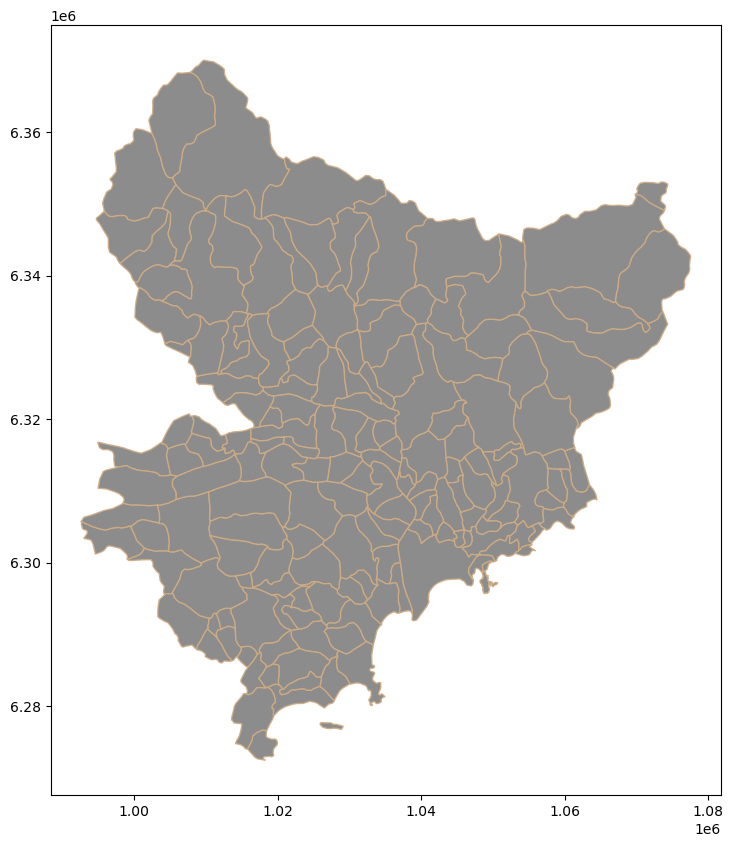

In [25]:
shp.plot(figsize=(12,10),
                color="gray",
                alpha=0.9,
                edgecolor="#CFAC84",
                linewidth=1)

In [26]:
df1 = pd.read_excel('Data/INSEE_incendie.xlsx')
df1.head()

,INSEE,Nombre d'incendies,Somme d'incendies (m2)
0,04001,10,34105
1,04004,13,754412
2,04005,8,66970
3,04006,2,41200
4,04007,2,500


In [27]:
shp_inc = shp.merge(df1, left_on='INSEE_COM', right_on='INSEE', how='left')
shp_inc.columns

Index(['ID_GEOFLA', 'CODE_COM', 'INSEE_COM', 'NOM_COM', 'STATUT', 'X_CHF_LIEU',
       'Y_CHF_LIEU', 'X_CENTROID', 'Y_CENTROID', 'Z_MOYEN', 'SUPERFICIE',
       'POPULATION', 'CODE_ARR', 'CODE_DEPT', 'NOM_DEPT', 'CODE_REG',
       'NOM_REG', 'Nombre d'i', 'Somme d'in', 'geometry', 'INSEE',
       'Nombre d'incendies', 'Somme d'incendies (m2)'],
      dtype='object')

In [28]:
vege = gpd.read_file('Data/zone_de_vegetation_reprojete.shp')

In [29]:
joined = gpd.overlay(shp, vege, how='intersection')
joined['Area'] = joined['geometry'].area

In [30]:
joined['geometry'] = joined['geometry'].centroid

In [31]:
# Check and rename conflicting columns in shp
if 'index_left' in shp.columns or 'index_right' in shp.columns:
    shp = shp.rename(columns={'index_left': 'index_left_orig', 'index_right': 'index_right_orig'})

# Check and rename conflicting columns in joined
if 'index_left' in joined.columns or 'index_right' in joined.columns:
    joined = joined.rename(columns={'index_left': 'index_left_orig', 'index_right': 'index_right_orig'})

point_in_poly = gpd.sjoin(left_df=shp, right_df=joined, how="left", predicate="contains")
result = point_in_poly.groupby(point_in_poly.index).agg({
    'Area': 'sum'            # Sum of areas for points in each polygon
}).rename(columns={'Area': 'Surface vegetation en m2'})
shp_with_counts = shp.join(result)
shp_with_counts['Ratio'] = round((shp_with_counts['Surface vegetation en m2'] / shp_with_counts['geometry'].area) * 100, 2)

In [32]:
shp_with_counts.columns

Index(['ID_GEOFLA', 'CODE_COM', 'INSEE_COM', 'NOM_COM', 'STATUT', 'X_CHF_LIEU',
       'Y_CHF_LIEU', 'X_CENTROID', 'Y_CENTROID', 'Z_MOYEN', 'SUPERFICIE',
       'POPULATION', 'CODE_ARR', 'CODE_DEPT', 'NOM_DEPT', 'CODE_REG',
       'NOM_REG', 'Nombre d'i', 'Somme d'in', 'geometry',
       'Surface vegetation en m2', 'Ratio'],
      dtype='object')

In [33]:
insee_stats = shp_inc.merge(shp_with_counts[['INSEE_COM', 'Surface vegetation en m2', 'Ratio']], on='INSEE_COM', how='inner')

In [34]:
insee_stats.head()

,ID_GEOFLA,CODE_COM,INSEE_COM,NOM_COM,STATUT,X_CHF_LIEU,Y_CHF_LIEU,X_CENTROID,Y_CENTROID,Z_MOYEN,...,CODE_REG,NOM_REG,Nombre d'i,Somme d'in,geometry,INSEE,Nombre d'incendies,Somme d'incendies (m2),Surface vegetation en m2,Ratio
0,COMMUNE00000000000000009,097,06097,PIERREFEU,Commune simple,1028827,6315717,1027327,6316879,752,...,93,PROVENCE-ALPES-COTE D'AZUR,19.0,353940.0,"POLYGON ((1029591.100 6315420.300, 1029545.200...",06097,19.0,353940.0,2.182792e+07,96.89
1,COMMUNE00000000000000117,140,06140,LE TIGNET,Commune simple,1010161,6288677,1010603,6288646,226,...,93,PROVENCE-ALPES-COTE D'AZUR,39.0,713630.0,"POLYGON ((1009848.900 6286949.200, 1009864.300...",06140,39.0,713630.0,8.321313e+06,73.48
2,COMMUNE00000000000000141,128,06128,SAINT-PAUL-DE-VENCE,Commune simple,1032245,6297257,1032298,6297129,142,...,93,PROVENCE-ALPES-COTE D'AZUR,25.0,202230.0,"POLYGON ((1030053.000 6298057.400, 1030063.200...",06128,25.0,202230.0,3.280113e+06,47.62
3,COMMUNE00000000000000547,152,06152,VALBONNE,Commune simple,1023413,6290680,1024562,6289556,189,...,93,PROVENCE-ALPES-COTE D'AZUR,102.0,461631.0,"POLYGON ((1028530.800 6287707.500, 1028455.400...",06152,102.0,461631.0,1.297303e+07,66.04
4,COMMUNE00000000000000781,044,06044,LA COLLE-SUR-LOUP,Commune simple,1030810,6296083,1029992,6296347,142,...,93,PROVENCE-ALPES-COTE D'AZUR,21.0,75900.0,"POLYGON ((1028752.500 6298075.600, 1028747.300...",06044,21.0,75900.0,5.300564e+06,52.93


In [35]:
# Changer la médiane par la majorité !!(Rim)
insee_stats['climat_majority'] = pd.DataFrame(
    zonal_stats(
        vectors=insee_stats['geometry'], 
        raster='Data/typologie_climat_decoupe_reprojete.tif',
        stats='majority'
    )
)

c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\main.py:151: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:


In [36]:
insee_stats['mnt_mean'] = pd.DataFrame(
    zonal_stats(
        vectors=insee_stats['geometry'], 
        raster='Data/mnt_alpes.tif',
        stats='mean'
    )
)

c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\main.py:151: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [37]:
# Changer la médiane par la majorité !!(Rim)
insee_stats['vitesseVent10m_majority'] = pd.DataFrame(
    zonal_stats(
        vectors=insee_stats['geometry'], 
        raster='Data/vitesseVent10m.tif',
        stats='majority',
        band=4
    )
)

c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\main.py:151: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [38]:
insee_stats.columns

,ID_GEOFLA,CODE_COM,INSEE_COM,NOM_COM,STATUT,X_CHF_LIEU,Y_CHF_LIEU,X_CENTROID,Y_CENTROID,Z_MOYEN,...,Somme d'in,geometry,INSEE,Nombre d'incendies,Somme d'incendies (m2),Surface vegetation en m2,Ratio,climat_majority,mnt_mean,vitesseVent10m_majority
0,COMMUNE00000000000000009,097,06097,PIERREFEU,Commune simple,1028827,6315717,1027327,6316879,752,...,353940.0,"POLYGON ((1029591.100 6315420.300, 1029545.200...",06097,19.0,353940.0,2.182792e+07,96.89,6.0,734.674790,3.0
1,COMMUNE00000000000000117,140,06140,LE TIGNET,Commune simple,1010161,6288677,1010603,6288646,226,...,713630.0,"POLYGON ((1009848.900 6286949.200, 1009864.300...",06140,39.0,713630.0,8.321313e+06,73.48,8.0,225.318062,3.0
2,COMMUNE00000000000000141,128,06128,SAINT-PAUL-DE-VENCE,Commune simple,1032245,6297257,1032298,6297129,142,...,202230.0,"POLYGON ((1030053.000 6298057.400, 1030063.200...",06128,25.0,202230.0,3.280113e+06,47.62,8.0,150.097012,2.0
3,COMMUNE00000000000000547,152,06152,VALBONNE,Commune simple,1023413,6290680,1024562,6289556,189,...,461631.0,"POLYGON ((1028530.800 6287707.500, 1028455.400...",06152,102.0,461631.0,1.297303e+07,66.04,8.0,188.402933,2.0
4,COMMUNE00000000000000781,044,06044,LA COLLE-SUR-LOUP,Commune simple,1030810,6296083,1029992,6296347,142,...,75900.0,"POLYGON ((1028752.500 6298075.600, 1028747.300...",06044,21.0,75900.0,5.300564e+06,52.93,8.0,133.289637,2.0


In [39]:
insee_stats.to_file('Data/insee_stats_python.shp')

C:\Users\SALAMA Ayoub\AppData\Local\Temp\ipykernel_13384\1302828736.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  insee_stats.to_file('Data/insee_stats_python.shp')
